In [21]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as p9
import matplotlib.cm as cmap
import seaborn as sns
import scipy.stats as st
import time
import os
import pickle

In [4]:
# Configurations
save_stats = False
save_figs = True
load = True

## 0. Utils for Q-Learning

In [5]:
def epsilon_greedy_action(grid, Q, epsilon):
    """
    Performs a (1-epsilon)-greedy action starting from a given state and given Q-values
    :param grid: current state
    :param Q: current Q-values
    :param epsilon: exploration parameter
    :return: the chosen action
    """
    # get the available positions
    avail_indices, avail_mask = available(grid)

    if np.random.uniform(0,1) < epsilon:
         # with probability epsilon make a random move (exploration)
        return avail_indices[np.random.randint(0, len(avail_indices))]
    else:
        # with probability 1-epsilon choose the action with highest immediate reward (exploitation)
        q = Q[encode_state(grid)]
        q[np.logical_not(avail_mask)] = np.nan # set all the Q(state, action) with action currently non available to nan 
        max_indices = np.argwhere(q == np.nanmax(q)) # best action(s) along the available ones
        return int(max_indices[np.random.randint(0, len(max_indices))]) # ties are split randomly

class QPlayer:
    """
    Class to implement a player that plays according to the greedy policy defined by (empirical estimastes of) the Q-values.
    """
    def __init__(self, Q, player='X'):
        """
        __init__
        :param self: self
        :param Q: Q-values
        :param player: 'X' or 'O'
        """
        self.Q = Q # initialize Q-values
        self.player = player

    def set_player(self, player='X', j=-1):
        """
        Set player to be either 'X' or 'O'
        :param self: self
        :param player: 'X' or 'O' ('X' by default)
        :param j: to change 'X' and 'O'
        """
        self.player = player
        if j != -1:
            self.player = 'X' if j % 2 == 0 else 'O'

    def act(self, grid, **kwargs):
        """
        Performs a greedy move, i.e. a (1-epsilon)-greedy action with epsilon equal to zero
        :param self: self
        :param grid: current state
        :param kwargs: keyword arguments
        :return: the action chosen greedily
        """
        return epsilon_greedy_action(grid, self.Q, 0)
    
def measure_performance(player_1, player_2, num_episodes = 500):
    """
    Measures performance of player 1 against player 2
    :param player_1: first player (usually a QPlayer member)
    :param player_2: second player (usually a OptimalPlayer member)
    :param num_episodes: number of episodes played
    :return: percentage of wins of player_1 against player_2
    """
    meas = 0
    turns = np.array(['X','O'])
    env = TictactoeEnv() # setting the environment
    for itr in range(num_episodes):
        env.reset() # reset at the beginning of each episode
        grid, _, _ = env.observe()
        # alternating the turns to start
        player_1.set_player(turns[itr%2])
        player_2.set_player(turns[(itr+1)%2])
        while not env.end:
            if env.current_player == player_1.player:
                move = player_1.act(grid) # move of the first player
            else:
                move = player_2.act(grid) # move of the second player
            grid, _, _ = env.step(move, print_grid=False) # updating the environment
        meas += env.reward(player=player_1.player) # updating the reward of player_1
    return meas/num_episodes

def running_average(vec, windows_size = 250):
    """
    Computes the running average of vec every windows_size elements
        Example: if windows_size=250 then it computes the mean of vec from 1 to 250, from 251 to 500 and so on.
    :param vec: numpy.ndarray
    :param windows_size: windows_size
    :return: mean of vec every windows_size elements
    """
    idx = np.arange(0, len(vec), windows_size) # (i * windows_size for i = 1, ..., len(vec) / windows_size))
    return [np.sum(vec[i:i+windows_size])/windows_size for i in idx], idx + windows_size

def encode_state(state):
    """
    Construct Python bytes containing the raw data bytes in the array representing the state.
    :param state: numpy.ndarray
    :return: the bytes representation of the state
    """
    return state.tobytes()

def available(grid):
    """
    Return available positions given a grid
    :param grid: current state
    :return:
        - avail_indices: list of available indices
        - avail_mask: list of bool which is True in available positions, False otherwise
    """
    avail_indices = []
    avail_mask = [False] * 9
    for i in range(9):
        pos = (int(i/3), i % 3)
        if grid[pos] == 0:
            avail_indices.append(i) # add i to the available indices
            avail_mask[i] = True # set the mask of the position i to True
    return avail_indices, avail_mask

In [6]:
def q_learning_against_opt(env, alpha = 0.5, gamma = 0.99, num_episodes = 20000, epsilon_exploration = 0.1,
               epsilon_exploration_rule = None, epsilon_opt = 0.5, test_freq = None, verbose = False):
    """
    Trains a Q-Learning agent by playing against optimal strategy (up to an epsilon_opt level of randomness, i.e. in expectation the teacher plays the optimal move epsilon_opt % of the time)
    :param env: the environment
    :param alpha: learning rate
    :param gamma: discount rate for future rewards
    :param num_episodes: number of training episodes
    :param epsilon_exploration: exploration rate
        If epsilon_exploration_rule is None, at each iteration the action with the highest Q-value is taken with probability (1-epsilon_exploration)
    :param epsilon_exploration_rule: function mapping each positive integer to the exploitation epsilon of the corresponding episode.
        If epsilon_exploration_rule is not None, at episode number n during training the action with the highest Q-value is taken with probability (1-epsilon_exploration_rule(n))
    :param epsilon_opt: float, in [0, 1]. Probability of the teacher making a random action instead of the optimal action at any given time.
    :param test_freq: frequency (in number of episodes) of tests executed against optimal and fully random policies
    :param verbose: bool
    :return:
        - Q: empirical estimates of the Q-values
        - stats: dictionary of statistics collected during training
    """
    turns = np.array(['X','O'])
    # Q-values map
    # Dictionary that maps the np.ndarray.tobyte() representation of the grid to an array of action values
    Q = defaultdict(lambda: np.zeros(9))    # All Q-values are initialized to 0
    # Stats of training
    episode_rewards = np.empty(num_episodes)
    if test_freq is not None:
        episode_Mopt = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))]
        episode_Mrand = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))]
    else:
        episode_Mopt = [] # initialize
        episode_Mrand = [] # initialize
    if verbose and (test_freq is not None):
                print('Episode  0 :\tM_opt = ', episode_Mopt[0], '\tM_rand = ', episode_Mrand[0])
    # Rule for exploration
    if epsilon_exploration_rule is None:
        def epsilon_exploration_rule(n):
            return epsilon_exploration # if an exploration rule is not given, it is the constant one

    for itr in range(num_episodes):
        my_player = turns[itr % 2]
        player_opt = OptimalPlayer(epsilon=epsilon_opt, player=turns[(itr+1) % 2])
        env.reset()
        state, _, _ = env.observe()
        # First step of the adversarial
        if env.current_player == player_opt.player:
            move = player_opt.act(state)
            state, _, _ = env.step(move)
        action = epsilon_greedy_action(state, Q, epsilon_exploration_rule(itr+1))
        while not env.end:
            next_state, _, _ = env.step(action)     # Move according to the policy
            if not env.end:
                move = player_opt.act(next_state)   # Adversarial move
                next_state, _, _ = env.step(move)
            # Sarsa update rule
            reward = env.reward(player=my_player)
            if not env.end:
                next_action = epsilon_greedy_action(next_state, Q, epsilon_exploration_rule(itr+1))
                target = reward + gamma * Q[encode_state(next_state)][next_action]
            else:
                target = reward
            Q[encode_state(state)][action] += alpha * (target - Q[encode_state(state)][action])
            # Preparing for the next move
            state = next_state
            action = next_action

        episode_rewards[itr] = env.reward(player=my_player)

        # Testing the performance
        if (test_freq is not None) and ((itr+1)%test_freq == 0):
            M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
            M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
            episode_Mopt.append(M_opt)
            episode_Mrand.append(M_rand)
            if verbose:
                print('Episode ', itr+1, ':\tM_opt = ', M_opt, '\tM_rand = ', M_rand)
    # Dictionary of stats
    stats = {
        'rewards': episode_rewards,
        'test_Mopt': episode_Mopt,
        'test_Mrand': episode_Mrand,
    }
    return Q, stats

In [7]:
def q_learning_self_practice(env, alpha = 0.5, gamma = 0.99, num_episodes = 20000, epsilon_exploration = 0.1,
                             epsilon_exploration_rule = None, test_freq = None, verbose = False):
    """
    Trains a Q-Learning agent by self-practice (i.e. plays against itself).
    :param env: the environment
    :param alpha: learning rate
    :param gamma: discount rate for future rewards
    :param num_episodes: number of training episodes
    :param epsilon_exploration: exploration rate
        If epsilon_exploration_rule is None, at each iteration the action with the highest Q-value is taken with probability (1-epsilon_exploration)
    :param epsilon_exploration_rule: function mapping each positive integer to the exploitation epsilon of the corresponding episode.
        If epsilon_exploration_rule is not None, at episode number n during training the action with the highest Q-value is taken with probability (1-epsilon_exploration_rule(n))
    :param test_freq: frequency (in number of episodes) of tests executed against optimal and fully random policies
    :param verbose: bool
    :return:
        - Q: empirical estimates of the Q-values
        - stats: dictionary of statistics collected during training
    """
    turns = np.array(['X','O'])
    # Q-values map
    # Dictionary that maps the np.ndarray.tobyte() representation of the grid to an array of action values
    Q = defaultdict(lambda: np.zeros(9))    # All Q-values are initialized to 0
    # Stats of training
    episode_rewards = np.empty(num_episodes)
    # Stats of training
    if test_freq is not None:
        episode_Mopt = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))]
        episode_Mrand = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))]
    else:
        episode_Mopt = [] # initialize
        episode_Mrand = [] # initialize
    if verbose and (test_freq is not None):
                print('Episode  0 :\tM_opt = ', episode_Mopt[0], '\tM_rand = ', episode_Mrand[0])
    # Rule for exploration
    if epsilon_exploration_rule is None:
        def epsilon_exploration_rule(n):
            return epsilon_exploration # if no exploration rule is given, it is the constant one

    for itr in range(num_episodes):
        my_player = turns[itr % 2]
        env.reset()
        state, _, _ = env.observe()
        # First two turns outside the loop (at least five turns are played)
        action = epsilon_greedy_action(state, Q, epsilon_exploration_rule(itr + 1))
        state_adv, _, _ = env.step(action)
        action_adv = epsilon_greedy_action(state_adv, Q, epsilon_exploration_rule(itr + 1))
        while not env.end:
            # Adversarial turn
            state_adv, _, _ = env.observe()
            reward = - env.reward(player=env.current_player) # Reward of the player who made the last move
            next_state, _, _ = env.step(action_adv)
            # Player's turn
            if not env.end:
                next_action = epsilon_greedy_action(next_state, Q, epsilon_exploration_rule(itr + 1))
                target = reward + gamma * Q[encode_state(next_state)][next_action]
            else:   # action_adv is the one that makes the game end
                reward = - env.reward(player=env.current_player)    # reward of the player who made the game end, i.e. the adversary of the current player
                # Update for the adversary of the current player
                Q[encode_state(state_adv)][action_adv] += alpha * reward
                # Target for the current player
                target = - reward + gamma * Q[encode_state(next_state)][next_action]
            Q[encode_state(state)][action] += alpha * (target - Q[encode_state(state)][action])

            # Preparing for the next iteration
            action = action_adv
            state = state_adv
            action_adv = next_action

        episode_rewards[itr] = env.reward(player=my_player)
        
        # Testing the performance
        if (test_freq is not None) and ((itr+1)%test_freq == 0):
            M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
            M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
            episode_Mopt.append(M_opt)
            episode_Mrand.append(M_rand)
            if verbose:
                print('Episode ', itr+1, ':\tM_opt = ', M_opt, '\tM_rand = ', M_rand)
    
    # Dictionary of stats
    stats = {
        'rewards': episode_rewards,
        'test_Mopt': episode_Mopt,
        'test_Mrand': episode_Mrand,
    }
    return Q, stats

In [8]:
def plot_stats(stats_dict, vec_var, var_name, var_legend_name, save = False, decaying_exploration=False):
    """
    Creates the plots for reward, M_opt, M_rand
    :param stats_dict: dictionary containing the training statistics
    :param vec_var: vector of variables to plot (need to be keys of stats_dict)
    :param var_name: variables name for the purpose of saving the plots
    :param var_legend_name: variables name for the legend (latex format)
    :param save: True to save figures in output folder
    :param decaying_exploration: True to plot the episode at which the decay stops and the exploration rate becomes constant
    """
    # creating the environment for the two plots
    fig_reward, ax_reward = plt.subplots()
    fig_performance, ax = plt.subplots(1,2, figsize=(13.4,4.8))
    fig_performance.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12) # adjust the spacing between subplots

    for var in vec_var:
        (stats, M_opt, M_rand) = stats_dict[var]
        # Plot of the average reward during training
        running_average_rewards, x_reward = running_average(stats['rewards']) # compute average reward
        color = next(ax_reward._get_lines.prop_cycler)['color']
        ax_reward.plot(x_reward, running_average_rewards, label="$"+ var_legend_name +" = "+ str(var) +"$", color=color)
        if decaying_exploration: # if there is decay of epsilon with some parameter n_star plot also the episode at which the decay stops and the exploration rate becomes constant (epsilon_min)
            find_nearest = np.abs(x_reward - 7/8 * var).argmin() # from here constant 1-epsilon_min greedy policy
            if np.abs(x_reward - 7/8 * var).min() < 250: # no plot if the nearest value is too far away (think of n_star = 40000) 
                ax_reward.plot(x_reward[find_nearest], running_average_rewards[find_nearest], marker="o", color=color)
                ax_reward.vlines(x=x_reward[find_nearest], ymin=-0.8, ymax=0.8, color=color, ls='--')
        # Plot of M_opt and M_rand during training
        x_performance = np.arange(0, len(stats['rewards'])+1, len(stats['rewards']) / (len(stats['test_Mopt']) - 1))
        ax[0].plot(x_performance, stats['test_Mopt'], label="$"+ var_legend_name +" = "+ str(var) +"$", color=color)
        if decaying_exploration: # if there is decay of epsilon with some parameter n_star plot also the episode at which the decay stops and the exploration rate becomes constant (epsilon_min)
            find_nearest = np.abs(x_reward - 7/8 * var).argmin() # from here constant 1-epsilon_min greedy policy
            if np.abs(x_performance - 7/8 * var).min() < 250: # no plot if the nearest value is too far away (think of n_star = 40000) 
                ax[0].plot(x_performance[find_nearest], stats['test_Mopt'][find_nearest], marker="o", color=color)
                ax[0].vlines(x=x_performance[find_nearest], ymin=-1.0, ymax=1.0, color=color, ls='--')
        ax[1].plot(x_performance, stats['test_Mrand'], label="$"+ var_legend_name +" = "+ str(var) +"$", color=color)
        if decaying_exploration: # if there is decay of epsilon with some parameter n_star plot also the episode at which the decay stops and the exploration rate becomes constant (epsilon_min)
            find_nearest = np.abs(x_reward - 7/8 * var).argmin() # from here constant 1-epsilon_min greedy policy
            if np.abs(x_reward - 7/8 * var).min() < 250: # no plot if the nearest value is too far away (think of n_star = 40000) 
                ax[1].plot(x_performance[find_nearest], stats['test_Mrand'][find_nearest], marker="o", color=color)
                ax[1].vlines(x=x_performance[find_nearest], ymin=-1.0, ymax=1.0, color=color, ls='--')
        print(var_name + " =", var,": \tM_opt = ", M_opt, "\tM_rand = ", M_rand) # print the performance

    ax_reward.set_ylim([-1,1])
    ax_reward.set_xlabel('Episode')
    ax_reward.set_ylabel('Reward')
    ax_reward.set_title('Average reward during training')
    ax_reward.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                     fancybox=True, shadow=True, ncol=4, fontsize=10)  # legend below outside the plot


    ax[0].hlines(y=0, xmin=x_reward[0], xmax=x_reward[-1],
                 color='r', linestyle='--') # plot also the zero line for M_opt, as it is the highest M_opt achievable
    ax[0].set_ylim([-1,0.1])
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('$M_{opt}$')
    ax[0].set_title('$M_{opt}$ during training')

    ax[1].set_ylim([-1,1])
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('$M_{rand}$')
    ax[1].set_title('$M_{rand}$ during training')
    
    ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(1.1, -0.15),
                            fancybox=True, shadow=True, ncol=5, fontsize=10)  # unique legend for the two plots
    plt.show()
    
    # saving onto file
    if save:
        output_folder = os.path.join(os.getcwd(), 'figures') # set the output folder
        os.makedirs(output_folder, exist_ok=True)
        # saving figures in "png" format
        fig_performance.savefig(output_folder + '/performance_'+var_name+'.png', bbox_inches='tight')
        fig_reward.savefig(output_folder + '/rewards_'+var_name+'.png', bbox_inches='tight')
        # saving figures in "eps" format
        fig_performance.savefig(output_folder + '/performance_'+var_name+'.eps', format='eps', bbox_inches='tight')
        fig_reward.savefig(output_folder + '/rewards_'+var_name+'.eps', format='eps', bbox_inches='tight')

## 2. Q-Learning

In [9]:
def q_learning(env, alpha = 0.5, gamma = 0.99, num_episodes = 20000, epsilon_exploration = 0.1,
                             epsilon_exploration_rule = None, epsilon_opt = 0.5, test_freq = None, verbose = False, 
                             against_opt=False, self_practice=False):
    """
    Calls q_learning_against_opt if against_opt = True and q_learning_self_practice if self_practice = True
    """
    if (int(against_opt) + int(self_practice) != 1):
        raise ValueError("Please choose a training method")
    if against_opt:
        return q_learning_against_opt(env, alpha, gamma, num_episodes, epsilon_exploration,
                             epsilon_exploration_rule,  epsilon_opt, test_freq, verbose)
    else:
        return q_learning_self_practice(env, alpha, gamma, num_episodes, epsilon_exploration,
                             epsilon_exploration_rule, test_freq, verbose)

In [11]:
env = TictactoeEnv()

# Hyper-parameters
alpha = 0.05    # Learning rate
gamma = 0.99    # Discount factor
epsilon_opt = 0.5   # Optimal player's epsilon
num_episodes = 20000

### 2.1 Learning from experts

In [24]:
epsilon_vec_plot = np.array([0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
epsilon_vec = np.hstack((epsilon_vec_plot, np.setdiff1d(np.logspace(-4, -1, 10), epsilon_vec_plot)))

In [45]:
if not load:
    env = TictactoeEnv()
    stats_dict_eps = {}
    for epsilon in epsilon_vec:
        print("------------- Training with epsilon =", epsilon, "-------------")
        start = time.time()
        Q, stats = q_learning(env, num_episodes=num_episodes,
                              epsilon_exploration=epsilon, test_freq=250, verbose=False, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_eps.update({epsilon: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with epsilon =", epsilon, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_eps.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_eps, handle, protocol=pickle.HIGHEST_PROTOCOL)

epsilon = 0 : 	M_opt =  0.0 	M_rand =  0.896
epsilon = 0.005 : 	M_opt =  0.0 	M_rand =  0.8915
epsilon = 0.1 : 	M_opt =  -0.189 	M_rand =  0.7245
epsilon = 0.5 : 	M_opt =  -0.392 	M_rand =  0.652


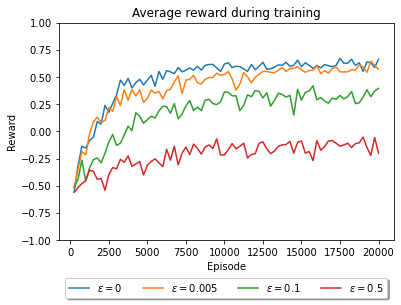

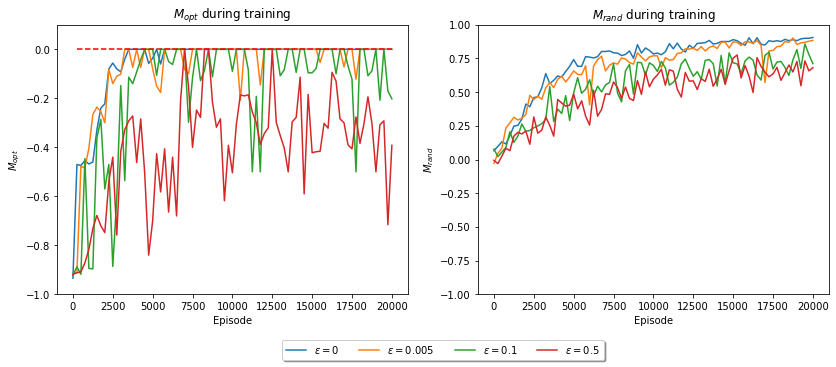

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [46]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps = pickle.load(handle)

plot_stats(stats_dict_eps, epsilon_vec_plot, "epsilon", "\epsilon", save=True)

In [50]:
epsilon_exploration = 0.1
Q, stats = q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, verbose=False, against_opt=True)

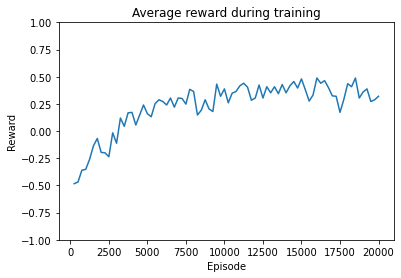


----- Trained  player-----
M_opt =  0.0
M_rand =  0.724
M_teacher =  0.49

----- Optimal  player-----
M_opt =  0.0
M_rand =  0.934
M_teacher =  0.622

----- Random  player-----
M_opt =  -0.906
M_rand =  -0.034
M_teacher =  -0.512


In [57]:
# Plotting the average reward for every 250 games during training
running_average_rewards, x = running_average(stats['rewards'])
fig = plt.figure()
plt.plot(x, running_average_rewards)
plt.ylim([-1,1])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average reward during training')
plt.show()
if save_figs:
        output_folder = os.path.join(os.getcwd(), 'figures')
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + '/rewards_Q1.png')
        fig.savefig(output_folder + '/rewards_Q1.eps', format = 'eps')

# Comparing the performance with the optimal player and the random player
turns = np.array(['X','O'])
player_opt = OptimalPlayer(epsilon=0.)
player_rand = OptimalPlayer(epsilon=1.)
teacher = OptimalPlayer(epsilon=0.5)

names = ['Trained', 'Optimal', 'Random']
players = [QPlayer(Q=Q), OptimalPlayer(epsilon=0.), OptimalPlayer(epsilon=1.)]

for (name, player) in zip(names, players):
    print("\n-----", name, " player-----")
    m_opt = measure_performance(player, player_opt)
    print("M_opt = ", m_opt)
    m_rand = measure_performance(player, player_rand)
    print("M_rand = ", m_rand)
    m_teacher = measure_performance(player, teacher)
    print("M_teacher = ", m_teacher)

#### 2.1.1 Decreasing exploration

In [29]:
test_freq = 250
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [30]:
if not load:
    stats_dict_nstar = {}
    for n_star in vec_n_star:
        print("------------- Training with n_star =", n_star, "-------------")
        def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
        start = time.time()
        Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, test_freq=test_freq, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_nstar.update({n_star: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with n_star =", n_star, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_nstar.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_nstar, handle, protocol=pickle.HIGHEST_PROTOCOL)

n_star_first = 1.0 : 	M_opt =  0.0 	M_rand =  0.6875
n_star_first = 24460.0 : 	M_opt =  -0.0915 	M_rand =  0.754
n_star_first = 40000 : 	M_opt =  0.0 	M_rand =  0.7325


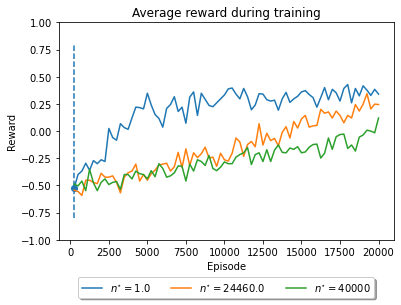

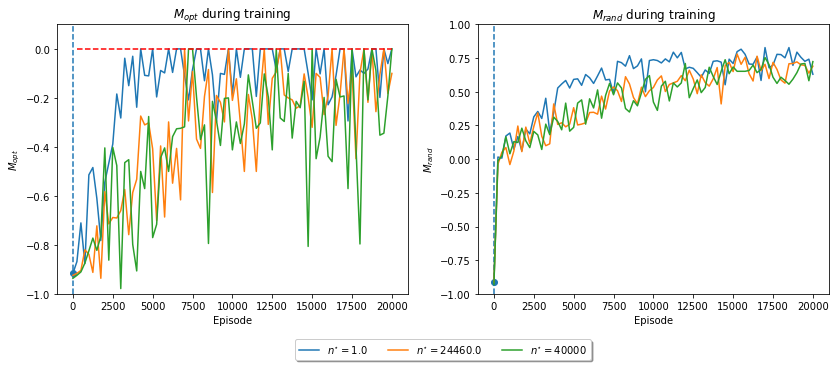

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


n_star_second = 1.0 : 	M_opt =  0.0 	M_rand =  0.6875
n_star_second = 4373.0 : 	M_opt =  0.0 	M_rand =  0.7895
n_star_second = 9146.0 : 	M_opt =  0.0 	M_rand =  0.7965


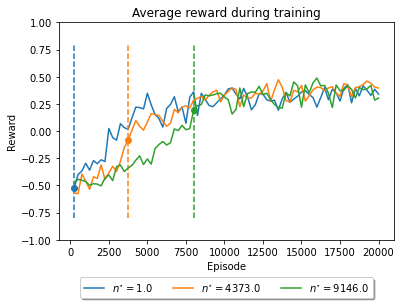

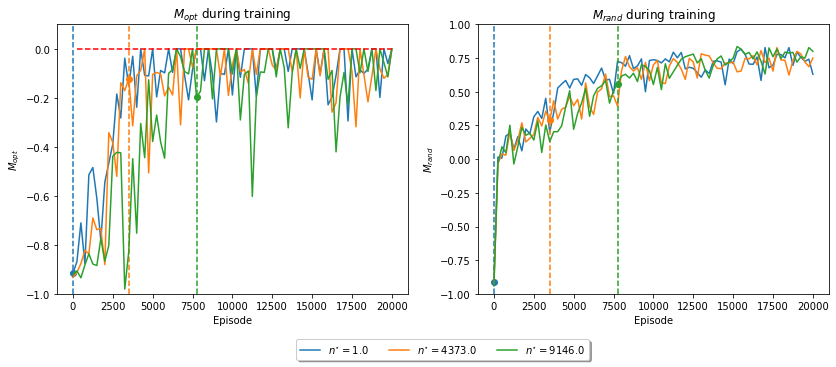

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [31]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar = pickle.load(handle)

plot_n_star = [1., 24460., 40000]
plot_stats(stats_dict_nstar, plot_n_star, 'n_star_first', "n^{\star}", save=True, decaying_exploration=True)

plot_n_star = [1., 4373., 9146.]
plot_stats(stats_dict_nstar, plot_n_star, 'n_star_second', "n^{\star}", save=True, decaying_exploration=True)
# plot_stats(stats_dict_nstar, vec_n_star, 'n_star', "n^{\star}", save=False)

#### 2.1.2 Good experts and bad experts

In [17]:
n_star = 4000 # this should be picked from before not inserted manually
M = 11
vec_epsilon_opt = np.linspace(0,1,M)

In [18]:
if not load:
    stats_dict_epsilon_opt = {}
    for epsilon_opt in vec_epsilon_opt:
        print("------------- Training with epsilon_opt =", epsilon_opt, "-------------")
        start = time.time()
        Q, stats = q_learning(env, epsilon_opt=epsilon_opt, test_freq=test_freq, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_epsilon_opt.update({epsilon_opt: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with epsilon_opt =", epsilon_opt, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_epsilon_opt.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_epsilon_opt, handle, protocol=pickle.HIGHEST_PROTOCOL)

epsilon_opt = 0.0 : 	M_opt =  0.0 	M_rand =  0.191
epsilon_opt = 0.5 : 	M_opt =  -0.098 	M_rand =  0.711
epsilon_opt = 1.0 : 	M_opt =  -0.264 	M_rand =  0.828


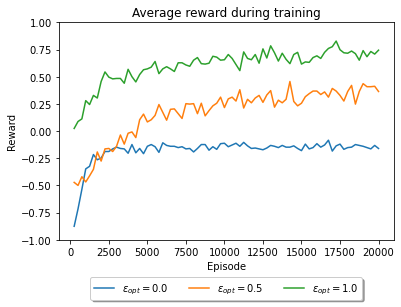

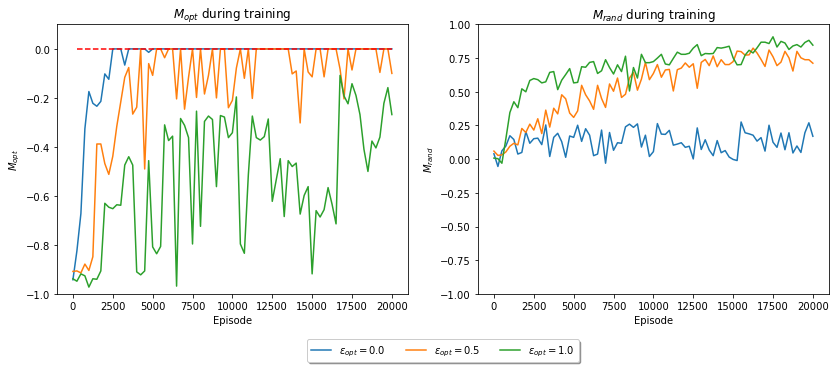

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [20]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_epsilon_opt.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_epsilon_opt = pickle.load(handle)

plot_epsilon_opt = [0., 0.5, 1.]
plot_stats(stats_dict_epsilon_opt, plot_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=True)
# plot_stats(stats_dict_epsilon_opt, vec_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=False)

### 2.2 Learning by self-practice

#### Question 7: Fixed $\epsilon$ first

In [35]:
epsilon_vec_plot = np.array([0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
epsilon_vec = np.hstack((epsilon_vec_plot, np.setdiff1d(np.logspace(-4, -1, 10), epsilon_vec_plot)))

In [36]:
if not load:
    env = TictactoeEnv()
    stats_dict_eps_self = {}
    for epsilon in epsilon_vec:
        print("------------- Training with epsilon =", epsilon, "-------------")
        Q, stats = q_learning(env, num_episodes=num_episodes,
                            epsilon_exploration=epsilon, test_freq = 250, verbose=False, self_practice=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_eps_self.update({epsilon: (stats, M_opt, M_rand)})

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_eps_self.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_eps_self, handle, protocol=pickle.HIGHEST_PROTOCOL)

epsilon_self = 0 : 	M_opt =  -0.7505 	M_rand =  0.2285
epsilon_self = 0.005 : 	M_opt =  -0.191 	M_rand =  0.683
epsilon_self = 0.1 : 	M_opt =  0.0 	M_rand =  0.919
epsilon_self = 0.5 : 	M_opt =  -0.3065 	M_rand =  0.726


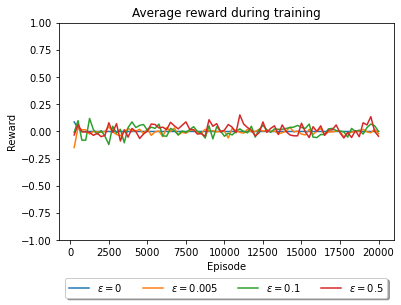

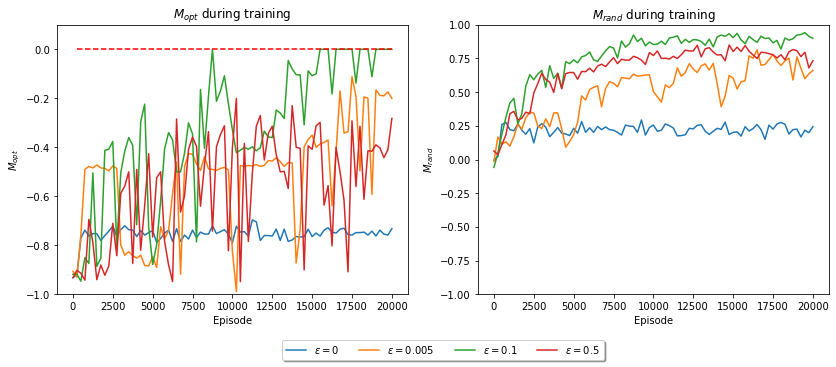

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


epsilon_self = 0.0 : 	M_opt =  -0.7505 	M_rand =  0.2285
epsilon_self = 0.0001 : 	M_opt =  -0.9285 	M_rand =  0.387
epsilon_self = 0.0005 : 	M_opt =  -0.6435 	M_rand =  0.4165
epsilon_self = 0.001 : 	M_opt =  -0.4875 	M_rand =  0.4275
epsilon_self = 0.005 : 	M_opt =  -0.191 	M_rand =  0.683
epsilon_self = 0.01 : 	M_opt =  -0.148 	M_rand =  0.8135
epsilon_self = 0.05 : 	M_opt =  -0.103 	M_rand =  0.928
epsilon_self = 0.1 : 	M_opt =  0.0 	M_rand =  0.919
epsilon_self = 0.5 : 	M_opt =  -0.3065 	M_rand =  0.726
epsilon_self = 1.0 : 	M_opt =  -0.9045 	M_rand =  0.5325
epsilon_self = 0.00021544346900318845 : 	M_opt =  -0.481 	M_rand =  0.3945
epsilon_self = 0.00046415888336127773 : 	M_opt =  -0.4855 	M_rand =  0.3995
epsilon_self = 0.002154434690031882 : 	M_opt =  -0.8455 	M_rand =  0.5495
epsilon_self = 0.004641588833612777 : 	M_opt =  -0.277 	M_rand =  0.622
epsilon_self = 0.021544346900318822 : 	M_opt =  0.0 	M_rand =  0.8455
epsilon_self = 0.046415888336127774 : 	M_opt =  -0.191 	M_rand 

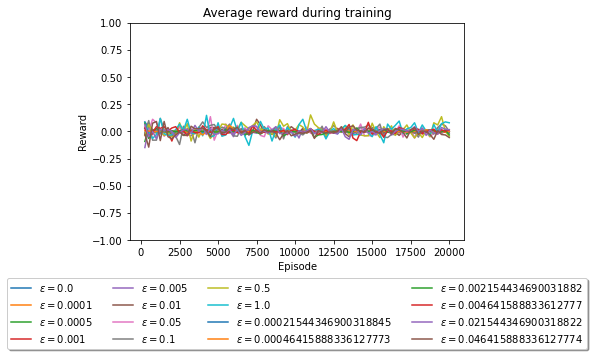

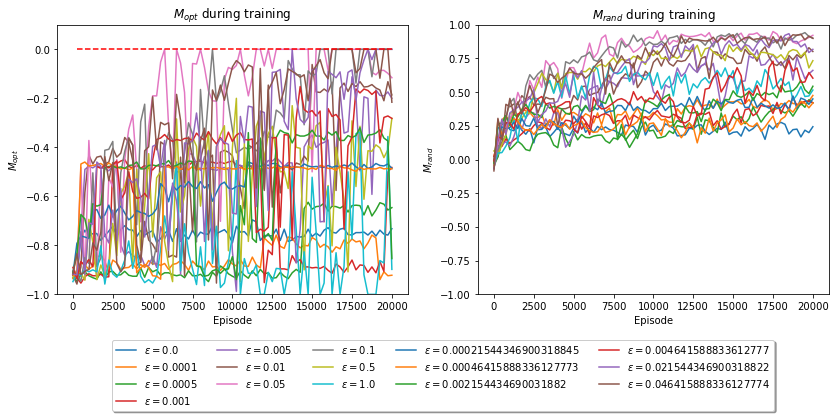

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [37]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps_self.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_self = pickle.load(handle)

epsilon_vec_plot = [0, 0.005, 0.1, 0.5]
plot_stats(stats_dict_eps_self, epsilon_vec_plot, "epsilon_self", "\epsilon", save=save_figs)
plot_stats(stats_dict_eps_self, epsilon_vec, "epsilon_self", "\epsilon", save=save_figs)

#### Question 8: Changing exploration rule, $\epsilon$ decay

In [38]:
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))
epsilon_min = 0.1
epsilon_max = 0.8

In [39]:
if not load:
    stats_dict_nstar_self = {}
    for n_star in vec_n_star:
        print("------------- Training with n_star =", n_star, "-------------")
        def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
        start = time.time()
        Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule,
                                test_freq=test_freq,  num_episodes=num_episodes, verbose=False, self_practice=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=200)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=200)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_nstar_self.update({n_star: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with n_star =", n_star, "took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_nstar_self.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_nstar_self, handle, protocol=pickle.HIGHEST_PROTOCOL)

n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.875
n_star = 4373.0 : 	M_opt =  0.0 	M_rand =  0.87
n_star = 24460.0 : 	M_opt =  0.0 	M_rand =  0.915
n_star = 40000 : 	M_opt =  -0.555 	M_rand =  0.8


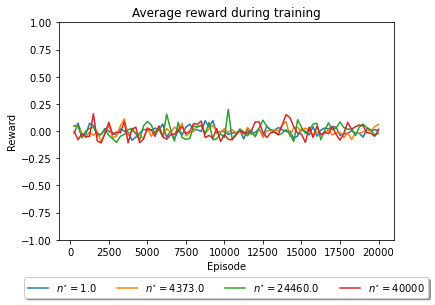

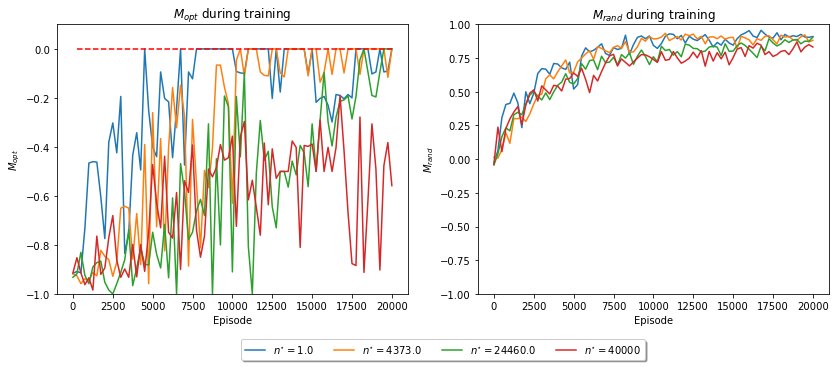

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.875
n_star = 4373.0 : 	M_opt =  0.0 	M_rand =  0.87
n_star = 9146.0 : 	M_opt =  0.0 	M_rand =  0.92


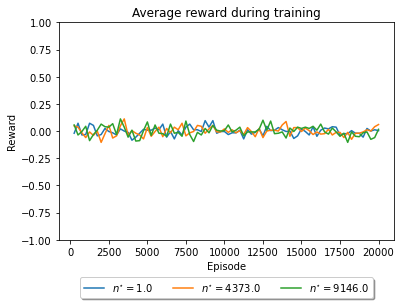

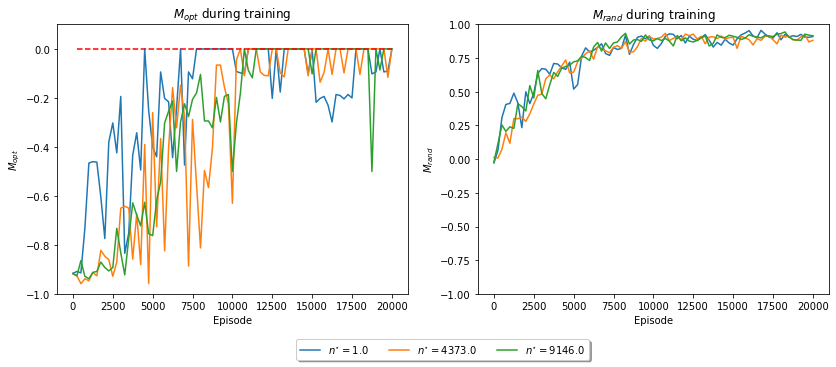

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.875
n_star = 100.0 : 	M_opt =  0.0 	M_rand =  0.91
n_star = 500.0 : 	M_opt =  0.0 	M_rand =  0.85
n_star = 750.0 : 	M_opt =  0.0 	M_rand =  0.955
n_star = 1000.0 : 	M_opt =  0.0 	M_rand =  0.935
n_star = 1279.0 : 	M_opt =  0.0 	M_rand =  0.88
n_star = 1635.0 : 	M_opt =  -0.12 	M_rand =  0.88
n_star = 2091.0 : 	M_opt =  0.0 	M_rand =  0.855
n_star = 2674.0 : 	M_opt =  -0.09 	M_rand =  0.92
n_star = 3420.0 : 	M_opt =  -0.09 	M_rand =  0.87
n_star = 4373.0 : 	M_opt =  0.0 	M_rand =  0.87
n_star = 5593.0 : 	M_opt =  0.0 	M_rand =  0.92
n_star = 7152.0 : 	M_opt =  0.0 	M_rand =  0.88
n_star = 9146.0 : 	M_opt =  0.0 	M_rand =  0.92
n_star = 11696.0 : 	M_opt =  -0.085 	M_rand =  0.94
n_star = 14957.0 : 	M_opt =  0.0 	M_rand =  0.87
n_star = 19127.0 : 	M_opt =  -0.245 	M_rand =  0.885
n_star = 24460.0 : 	M_opt =  0.0 	M_rand =  0.915
n_star = 31279.0 : 	M_opt =  -0.315 	M_rand =  0.87
n_star = 40000.0 : 	M_opt =  -0.555 	M_rand =  0.8


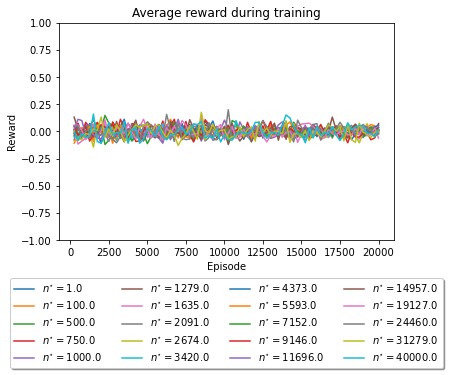

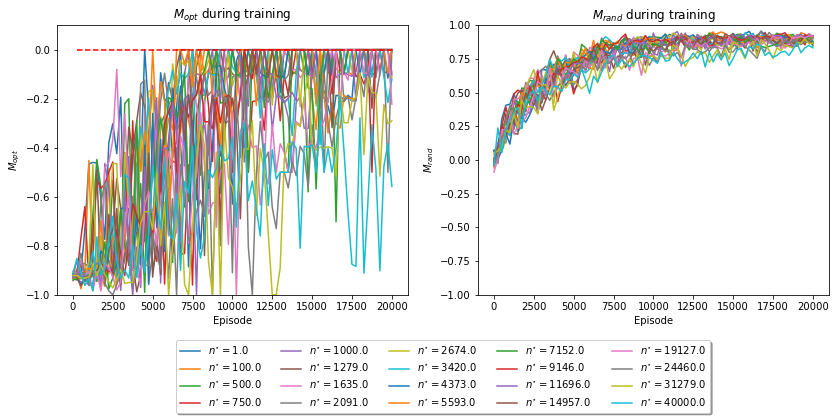

In [40]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_self.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_self = pickle.load(handle)

plot_n_star = [1., 4373., 24460., 40000]
plot_stats(stats_dict_nstar_self, plot_n_star, 'n_star', "n^{\star}", save=save_figs)

plot_n_star = [1., 4373., 9146.]
plot_stats(stats_dict_nstar_self, plot_n_star, 'n_star', "n^{\star}", save=save_figs)
plot_stats(stats_dict_nstar_self, vec_n_star, 'n_star', "n^{\star}", save=False)

#### Question 9: TODO look for optimal $M_{opt}$ and $M_{rand}$

In [41]:
### look for optimal values of M_opt and M_rand

#### Question 10: heat maps in 3 different states

In [12]:
# Parametri ottimali di Q
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 4373
def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, num_episodes=20000, verbose=True, self_practice=True)

In [63]:
def plot_qtable(grid, Q, save = False, saving_name = None):
    text_lut = {0: np.nan, 1: 'X', -1: 'O'}
    q_vals = Q[encode_state(grid)][:]
    q_vals = q_vals.round(decimals = 2)
    plot_data = pd.DataFrame({'x': np.tile([1, 2, 3], 3), 'y': np.repeat([1, 2, 3], 3),
                          'board_state': [text_lut[val] for val in grid.flatten()],
                          'q_values': q_vals})
    plot = p9.ggplot(plot_data, p9.aes(x = 'x', y = 'y')) + \
                p9.geom_tile(p9.aes(fill = 'q_values'), show_legend=False) + \
                p9.geom_text(p9.aes(label = 'board_state'), color = 'white', size=50) + \
                p9.geom_text(p9.aes(label="q_values"), show_legend=False) + \
                p9.scale_fill_gradient2() + \
                p9.scale_y_reverse() + \
                p9.theme(figure_size=(4,4), axis_text=p9.element_blank(), axis_ticks=p9.element_blank(),
                      strip_text_x=p9.element_blank(), axis_title=p9.element_blank())

    # saving onto file
    if save:
        output_folder = os.path.join(os.getcwd(), 'figures/') # set the output folder
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + saving_name
        plot.save(filename = fname + '.png')
        plot.save(filename = fname + '.eps')

In [64]:
grids = [[1., 0., 0., -1., 1., 0., 0., -1., 0.], [-1., 0., 0., 1., 0., 0., 0., 1., -1.], [1., -1., 0., 0., 0., 0., 0., 0., 0.]]
for (num, grid) in enumerate(grids):
    grid = np.array(grid)
    name = 'heatmap_' + str(num)
    plot_qtable(grid, Q, save=True, saving_name=name)



C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: C:\Users\ivanb\Documents\GitHub\ANN_Project\code\figures/heatmap_0.png
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: C:\Users\ivanb\Documents\GitHub\ANN_Project\code\figures/heatmap_0.eps
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 

## Deep Q-Learning